##  Load packages and configure GPU

In [1]:
#!pip install tensorflow-models-official

In [2]:
import tensorflow as tf
import os, sys
import warnings
from cholect50 import dataloader_tf as dataloader
import matplotlib.pyplot as plt
import numpy as np

#os.environ['PYTHONPATH'] += ":/code/models"

#import tensorflow_models as tfm
#from tensorflow_models import vision
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ConvLSTM2D, TimeDistributed
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Layer
import tensorflow_addons as tfa

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")
%matplotlib inline

/home/mainuser/.local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[1],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*24)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


## Load train, test, val dataset using the Dataloader 

In [4]:
BATCH_SIZE = 8
SEQUENCE_DEPTH = 16

In [5]:
dataset = dataloader.CholecT50( 
          dataset_dir="CholecT50", 
          dataset_variant="cholect50",
          test_fold=1,
          augmentation_list=['original'],
          num_parallel_calls=100,
          num_sequence = SEQUENCE_DEPTH
          )

# build dataset
train_dataset, val_dataset, test_dataset = dataset.build()

# train and val data loaders
train_dataloader = train_dataset.batch(BATCH_SIZE) # see tf.data.Dataset for more options
val_dataloader   = val_dataset.batch(BATCH_SIZE)

# test data set is built per video, so load differently
test_dataloaders = []
for video_dataset in test_dataset:
    test_dataloader = video_dataset.batch(BATCH_SIZE)
    test_dataloaders.append(test_dataloader)  

## Inspect Dataset

(8, 16, 256, 448, 3)
(16, 256, 448, 3)


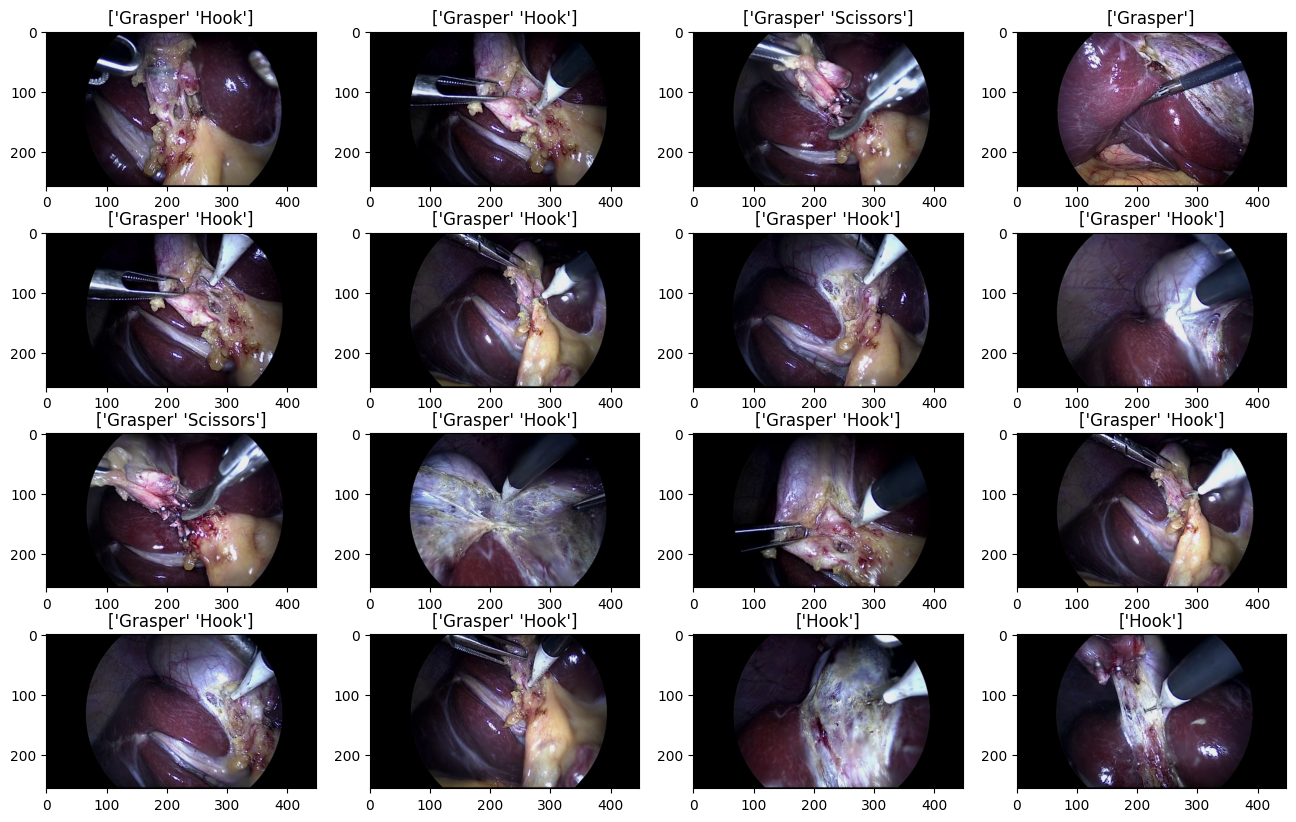

In [6]:
# Given instruments in the dataset
instruments = np.array([
    "Grasper",
    "Bipolar",
    "Hook",
    "Scissors",
    "Clipper",
    "Irrigator"
])

# Take 1 batch of image sequences from the train_dataloader
for (img_list, (ivt_list, i_list, v_list, t_list, p_list)) in train_dataloader.take(1):
    break
    
print(img_list.shape)

# Print sequence of images in a single batch
img_seq = img_list[0]
label_seq = i_list[0]

print(img_seq.shape)

plt.subplots(4,4,figsize=(16,10))

for idx in range(0, SEQUENCE_DEPTH):
    img = img_seq[idx].numpy()
    label = instruments[label_seq[idx] == 1]
    plt.subplot(4,4,idx+1)
    plt.imshow(img.astype(np.uint8))
    plt.title(str(label))

## Model

In [7]:
from tensorflow.keras.layers import Layer

NUM_FRAMES = 16
BATCH_SIZE = 8

class ReshapeLayer(Layer):
    def call(self,inputs):
        nshape = (BATCH_SIZE,NUM_FRAMES) + inputs.shape[1:]
        return tf.reshape(inputs,nshape)
    
class ExpandLayer(Layer):
    def call(self,inputs):
        nshape = (BATCH_SIZE,NUM_FRAMES) + inputs.shape[1:]
        return tf.reshape(inputs,nshape)
    
def wildcat_pooling(img, alpha=0.6, name='Wildcat_Pooling'):
    # Axis: Breadth and Width of the input tensor. Assuming
    # 0 is the batch size. Check if we have a 5D Tensor
    with tf.name_scope(name):
        return tf.math.reduce_max(img, axis=[-3,-2]) + alpha*tf.math.reduce_min(img, axis=[-3,-2])

In [8]:
# Define the input as a tensor with shape input_shape
filters = [64, 128, 256, 512]
strides = [1,   2,   1,   1]

X_input = Input(shape = (256, 448, 3))


# Zero-Padding
X = ZeroPadding2D((3, 3))(X_input)


#[Note]: Using ResNet50-V1 instead 


# Stage 1
X = Conv2D(64, (7, 7), 
           strides=(2, 2), 
           name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(name='bnConv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

for i in range(len(filters)):
    if (i > 0): 
        X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=True)(X)
        X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=True)(X)
    else:
        X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=False)(X)
        X = vision.layers.ResidualBlock(filters[i], strides[i], use_projection=False)(X)
"""        

X = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 448, 3),
    include_top=False
)(X_input)
"""

reshaped_input = ReshapeLayer()(X)

# # Return sequence True will return all the sequence of images
# # if set to false, it will only return the last image 
X = ConvLSTM2D(
     filters=6,
     kernel_size=(1, 1), 
     name='convLSTMLayer', 
     kernel_regularizer = regularizers.L2(1e-5),
     return_sequences=True)(reshaped_input)

# Wildcat Pooling goes here

# Need to move after ConvLSTM in final
X = Conv2D(filters=6, kernel_size=(1, 1), name='LocMapLayer')(X)


model = Model(inputs=X_input, outputs=X, name='WNet')

NameError: name 'vision' is not defined

In [ ]:
model.summary()

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

In [ ]:
#### WITH RESNET18 PRETRAINED
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')

X_input = Input(shape = (256, 448, 3))

X = ResNet18(input_shape=(256, 448, 3), weights='imagenet', include_top=False)(X_input)


reshaped_input = ReshapeLayer()(X)

# # Return sequence True will return all the sequence of images
# # if set to false, it will only return the last image 
# X = ConvLSTM2D(
#     filters=6,
#     kernel_size=(1, 1), 
#     name='convLSTMLayer', 
#     kernel_regularizer = regularizers.L2(1e-5),
#     return_sequences=True)(reshaped_input)

X = ConvLSTM2D(
     filters=6,
     kernel_size=(1, 1), 
     name='convLSTMLayer', 
     kernel_regularizer = regularizers.L2(1e-5),
     return_sequences=True)(reshaped_input)

# Wildcat Pooling goes here

# Need to move after ConvLSTM in final
X = Conv2D(filters=6, kernel_size=(1, 1), name='LocMapLayer')(X)


model = Model(inputs=X_input, outputs=X, name='WNet')

In [ ]:
model.summary()

In [ ]:
pretrained_model_for_demo = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 448, 3)
)

## Model v1

In [9]:
from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet = ResNet18(input_shape=(256, 448, 3), weights='imagenet', include_top=False)

X_input = Input(shape = (SEQUENCE_DEPTH, 256, 448, 3))
reshaped_input = TimeDistributed(resnet)(X_input)
X = ConvLSTM2D(
     filters=6,
     kernel_size=(1, 1), 
     name='convLSTMLayer', 
     kernel_regularizer = regularizers.L2(1e-5),
     return_sequences=True)(reshaped_input)

X = Conv2D(filters=6, kernel_size=(1, 1), name='LocMapLayer')(X)
X = wildcat_pooling(X)

model = Model(inputs=X_input, outputs=X, name='WNet')

model.summary()

Model: "WNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 256, 44  0           []                               
                                8, 3)]                                                            
                                                                                                  
 time_distributed (TimeDistribu  (None, 16, 8, 14, 5  11186889   ['input_2[0][0]']                
 ted)                           12)                                                               
                                                                                                  
 convLSTMLayer (ConvLSTM2D)     (None, 16, 8, 14, 6  12456       ['time_distributed[0][0]']       
                                )                                                              

## Train model

In [10]:
from tensorflow.nn import weighted_cross_entropy_with_logits as loss_fn

In [11]:
class_weights = tf.convert_to_tensor(
    [0.08084519, 0.81435289, 0.10459284, 2.55976864, 1.630372490, 1.29528455], 
    dtype=tf.float32, dtype_hint=None, name=None
)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=['accuracy']
)

In [22]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))


    # Iterate over the batches of the dataset.
    for step, (img, (_, label_i, _, _, _)) in enumerate(train_dataloader):
               
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(img, training=True)  # Logits for this minibatch
            logits  = tf.sigmoid(logits)
            
            #print(label_i,logits)
            
            #label_i=tf.cast(label_i,tf.float32)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(labels=label_i, logits=logits, pos_weight=class_weights)
            #loss_value = tf.expand_dims(tf.math.reduce_mean(loss_value, axis = -1),axis = -1)
            loss_value = tf.math.reduce_mean(loss_value)
            #print(loss_value)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 2 batches.
        if step % 1000 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))


Start of epoch 0
Training loss (for one batch) at step 0: 0.5842
Seen so far: 8 samples

Start of epoch 1
Training loss (for one batch) at step 0: 0.5486
Seen so far: 8 samples


# Model v2

In [ ]:
inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(180,320,3)
)
  
for layer in inceptionresnet.layers[:-4]:                                                       
    layer.trainable = False